### Importing packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import text
from datetime import datetime as dt
import seaborn as sns
import holidays
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
from pandas.plotting import register_matplotlib_converters, autocorrelation_plot
register_matplotlib_converters()

### Getting data

In [2]:
data_df = pd.read_csv('Data/ARIMA_Full_Data.csv')
data_df.order_date = pd.to_datetime(data_df.order_date)
data_df.index = data_df.order_date
data_df.head()

,order_date,new_customers,number_of_orders,total_delivery_charged,delivery_discount,total_revenue,reported_transactions,reported_revenue_local,cost_local,net_revenue,gross_total_revenue
order_date,,,,,,,,,,,
2016-02-10,2016-02-10,1.0,5,25.0,0.0,391.72,0.0,0.0,0.0,0.0,391.72
2016-02-11,2016-02-11,1.0,2,18.0,0.0,169.24,0.0,0.0,0.0,0.0,169.24
2016-02-12,2016-02-12,0.0,1,9.0,0.0,58.88,0.0,0.0,0.0,0.0,58.88
2016-02-13,2016-02-13,1.0,1,9.0,0.0,99.80,0.0,0.0,0.0,0.0,99.80
2016-02-15,2016-02-15,0.0,4,24.0,0.0,710.35,0.0,0.0,0.0,0.0,710.35


In [4]:
data_df.shape

(3647, 11)

### Trend of Sales

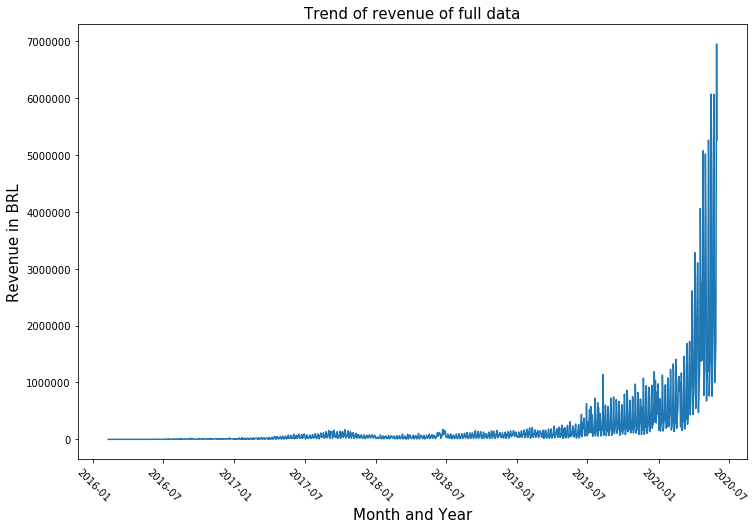

In [5]:
ax = plt.figure(figsize=(12,8))
plt.plot(data_df.order_date[:], data_df.gross_total_revenue[:])
plt.xticks(rotation=-45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Month and Year', fontsize=15)
plt.ylabel('Revenue in BRL', fontsize=15)
plt.title('Trend of revenue of full data', fontsize=15)
plt.show()

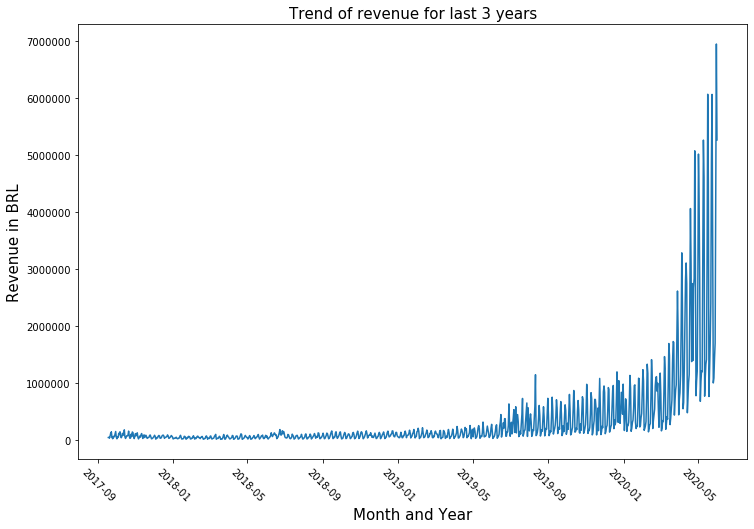

In [6]:
ax = plt.figure(figsize=(12,8))
plt.plot(data_df.order_date[-1000:], data_df.gross_total_revenue[-1000:])
plt.xticks(rotation=-45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Month and Year', fontsize=15)
plt.ylabel('Revenue in BRL', fontsize=15)
plt.title('Trend of revenue for last 3 years', fontsize=15)
plt.show()

### Seasonal Decomposition - Original Data

(1000,)


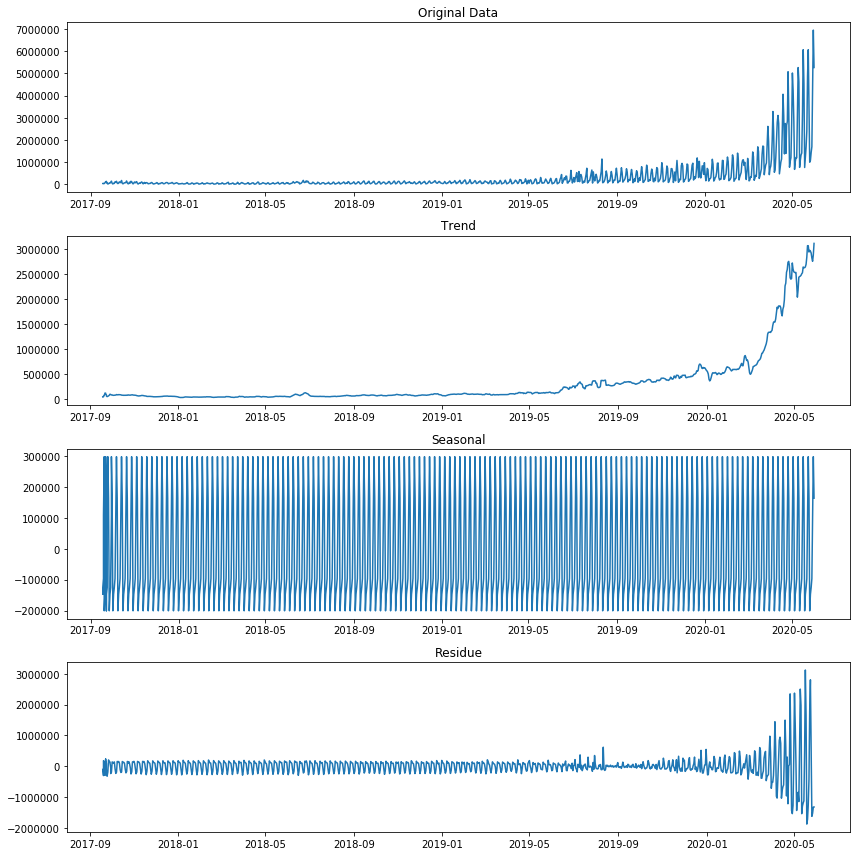

In [7]:
sales_data = data_df['gross_total_revenue'][-1000:]
print(sales_data.shape)
decomposition = seasonal_decompose(sales_data, model = 'additive', period=7) 
fig, ax = plt.subplots(4,1, figsize=(12,12))
ax[0].plot(sales_data)
ax[0].set_title('Original Data')
ax[1].plot(decomposition.trend)
ax[1].set_title('Trend')
ax[2].plot(decomposition.seasonal)
ax[2].set_title('Seasonal')
ax[3].plot(decomposition.resid)
ax[3].set_title('Residue')
plt.tight_layout()

### ADF Test - Original Data
<hr/>

In [8]:
result = adfuller(sales_data)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 4.348983929637403
p-value: 1.0
Critical Values:
	1%: -3.43706091543889
	5%: -2.8645028204932483
	10%: -2.568347558984588


### KPSS Test - Original Data
<hr/>

In [9]:
result = kpss(sales_data)
print('KPSS Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[3].items():
    print('\t{}: {}'.format(key, value))

KPSS Statistic: 2.0552959444626837
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


c:\program files\python38\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\program files\python38\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


## Making data stationary
<hr />

### Using log transform

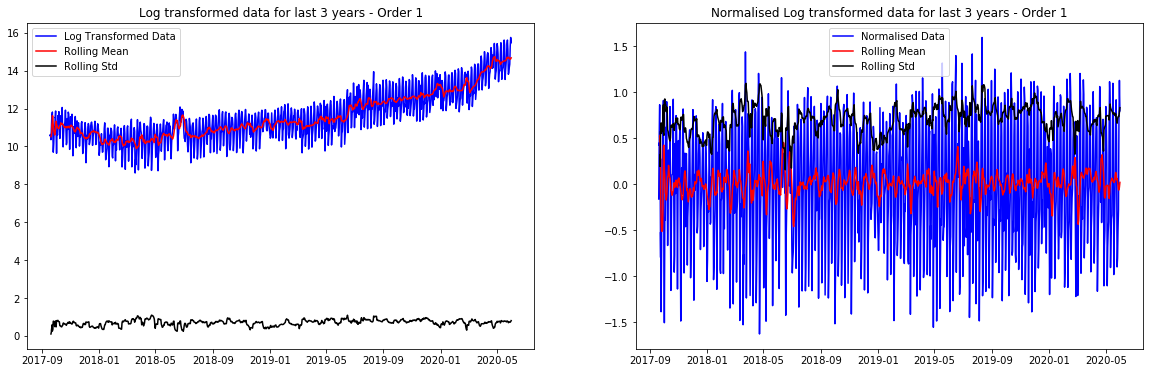

(1000,)
(994,)
The critical params are: 


,log,normalised log
count,1000.000000,994.000000
mean,11.623134,0.013985
std,1.352461,0.677800
min,8.600679,-1.624861
25%,10.684048,-0.508465
50%,11.414077,0.056266
75%,12.383201,0.573577
max,15.753798,1.594416


In [10]:
log_sales = np.log(sales_data)

rolling_mean = log_sales.rolling(window = 7).mean()
rolling_std = log_sales.rolling(window = 7).std()
ax = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(log_sales, color = 'blue', label = 'Log Transformed Data')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Log transformed data for last 3 years - Order 1')


rolling_mean = log_sales.rolling(window=7).mean()
log_sales_minus_mean = log_sales - rolling_mean
log_sales_minus_mean.dropna(inplace=True)

rolling_mean = log_sales_minus_mean.rolling(window = 7).mean()
rolling_std = log_sales_minus_mean.rolling(window = 7).std()
plt.subplot(1,2,2)
plt.plot(log_sales_minus_mean, color = 'blue', label = 'Normalised Data')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Normalised Log transformed data for last 3 years - Order 1')
plt.show()

print(log_sales.shape)
print(log_sales_minus_mean.shape)

stat_df = pd.DataFrame(columns=['log', 'normalised log'], index=log_sales.describe().index.values)
stat_df['log'] = log_sales.describe().values
stat_df['normalised log'] = log_sales_minus_mean.describe().values
print('The critical params are: ')
stat_df

### Using differencing
<hr />

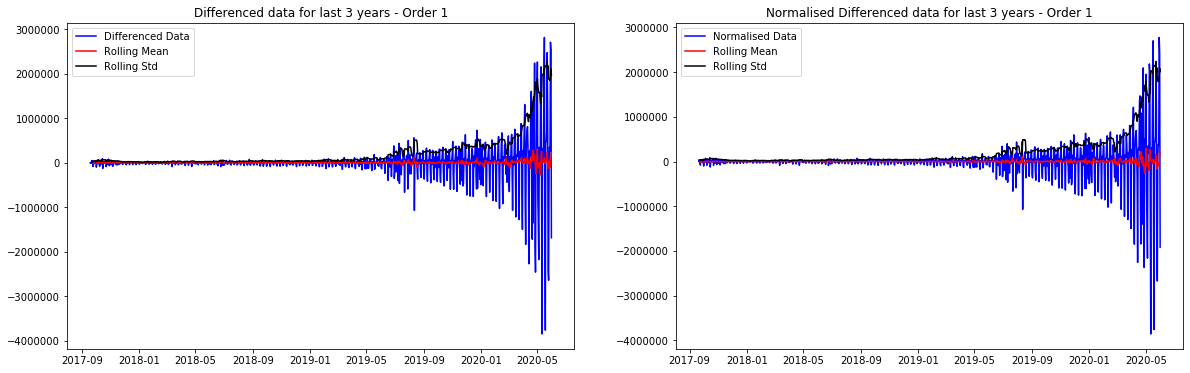

(1000,)
(993,)
The critical params are: 


,differenced,normalised differenced
count,9.990000e+02,9.930000e+02
mean,5.227715e+03,2.166038e+03
std,4.301680e+05,4.247087e+05
min,-3.846093e+06,-3.859064e+06
25%,-3.064434e+04,-3.023248e+04
50%,1.114282e+04,1.205660e+04
75%,4.820173e+04,4.712738e+04
max,2.816618e+06,2.776514e+06


In [11]:
diff_sales_1 = sales_data - sales_data.shift(1)

rolling_mean = diff_sales_1.rolling(window = 7).mean()
rolling_std = diff_sales_1.rolling(window = 7).std()
ax = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(diff_sales_1, color = 'blue', label = 'Differenced Data')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Differenced data for last 3 years - Order 1')


rolling_mean = diff_sales_1.rolling(window=7).mean()
diff_sales_1_minus_mean = diff_sales_1 - rolling_mean
diff_sales_1_minus_mean.dropna(inplace=True)

rolling_mean = diff_sales_1_minus_mean.rolling(window = 7).mean()
rolling_std = diff_sales_1_minus_mean.rolling(window = 7).std()
plt.subplot(1,2,2)
plt.plot(diff_sales_1_minus_mean, color = 'blue', label = 'Normalised Data')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Normalised Differenced data for last 3 years - Order 1')
plt.show()

print(diff_sales_1.shape)
print(diff_sales_1_minus_mean.shape)

stat_df = pd.DataFrame(columns=['differenced', 'normalised differenced'], index=log_sales.describe().index.values)
stat_df['differenced'] = diff_sales_1.describe().values
stat_df['normalised differenced'] = diff_sales_1_minus_mean.describe().values
print('The critical params are: ')
stat_df

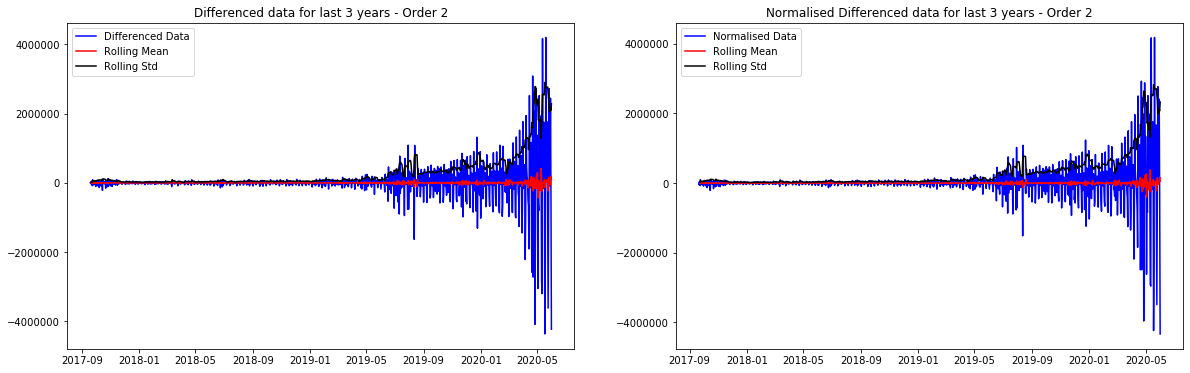

(1000,)
(992,)
The critical params are: 


,differenced-2,normalised differenced-2
count,9.980000e+02,9.920000e+02
mean,-1.688524e+03,-1.959805e+03
std,5.565247e+05,5.460366e+05
min,-4.362689e+06,-4.332158e+06
25%,-4.931000e+04,-4.753042e+04
50%,3.780393e+03,3.353722e+03
75%,5.016014e+04,4.803304e+04
max,4.199854e+06,4.183055e+06


In [12]:
diff_sales_2 = diff_sales_1 - diff_sales_1.shift(1)

rolling_mean = diff_sales_2.rolling(window = 7).mean()
rolling_std = diff_sales_2.rolling(window = 7).std()
ax = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(diff_sales_2, color = 'blue', label = 'Differenced Data')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Differenced data for last 3 years - Order 2')


rolling_mean = diff_sales_2.rolling(window=7).mean()
diff_sales_2_minus_mean = diff_sales_2 - rolling_mean
diff_sales_2_minus_mean.dropna(inplace=True)

rolling_mean = diff_sales_2_minus_mean.rolling(window = 7).mean()
rolling_std = diff_sales_2_minus_mean.rolling(window = 7).std()
plt.subplot(1,2,2)
plt.plot(diff_sales_2_minus_mean, color = 'blue', label = 'Normalised Data')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Normalised Differenced data for last 3 years - Order 2')
plt.show()

print(diff_sales_2.shape)
print(diff_sales_2_minus_mean.shape)

stat_df = pd.DataFrame(columns=['differenced-2', 'normalised differenced-2'], index=log_sales.describe().index.values)
stat_df['differenced-2'] = diff_sales_2.describe().values
stat_df['normalised differenced-2'] = diff_sales_2_minus_mean.describe().values
print('The critical params are: ')
stat_df

## Using differencing on log transform
<hr />

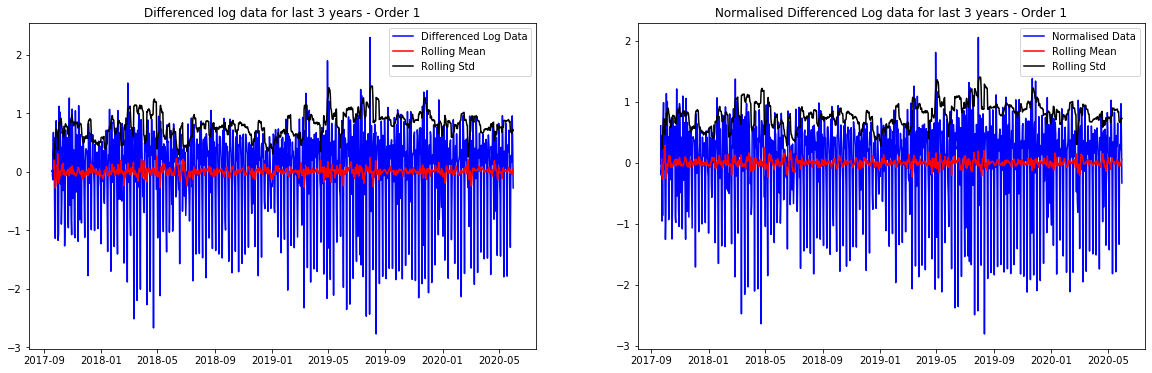

(1000,)
(999,)
(993,)
The critical params are: 


,differenced log,normalised differenced log
count,999.000000,993.000000
mean,0.004894,0.000964
std,0.760948,0.753056
min,-2.774725,-2.803982
25%,-0.305745,-0.311720
50%,0.207361,0.208051
75%,0.498887,0.498492
max,2.295669,2.054851


In [13]:
diff_log_sales = log_sales - log_sales.shift(1)
diff_log_sales.dropna(inplace=True)

rolling_mean = diff_log_sales.rolling(window = 7).mean()
rolling_std = diff_log_sales.rolling(window = 7).std()
ax = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(diff_log_sales, color = 'blue', label = 'Differenced Log Data')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Differenced log data for last 3 years - Order 1')


rolling_mean = diff_log_sales.rolling(window=7).mean()
diff_log_sales_minus_mean = diff_log_sales - rolling_mean
diff_log_sales_minus_mean.dropna(inplace=True)

rolling_mean = diff_log_sales_minus_mean.rolling(window = 7).mean()
rolling_std = diff_log_sales_minus_mean.rolling(window = 7).std()
plt.subplot(1,2,2)
plt.plot(diff_log_sales_minus_mean, color = 'blue', label = 'Normalised Data')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Normalised Differenced Log data for last 3 years - Order 1')
plt.show()

print(log_sales.shape)
print(diff_log_sales.shape)
print(diff_log_sales_minus_mean.shape)

stat_df = pd.DataFrame(columns=['differenced log', 'normalised differenced log'], index=log_sales.describe().index.values)
stat_df['differenced log'] = diff_log_sales.describe().values
stat_df['normalised differenced log'] = diff_log_sales_minus_mean.describe().values
print('The critical params are: ')
stat_df

### ADF Test - Differenced Log Data
<hr/>

In [14]:
result = adfuller(diff_log_sales)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -9.918294955478869
p-value: 3.0383816995626425e-17
Critical Values:
	1%: -3.437054035425408
	5%: -2.8644997864059363
	10%: -2.5683459429326576


### KPSS Test - Differenced Log Data
<hr/>

In [15]:
result = kpss(diff_log_sales)
print('KPSS Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[3].items():
    print('\t{}: {}'.format(key, value))

KPSS Statistic: 0.05478964939082174
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


c:\program files\python38\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


### Seasonal Decomposition - Differenced Log Data

(999,)
(999,)
(999,)
(999,)


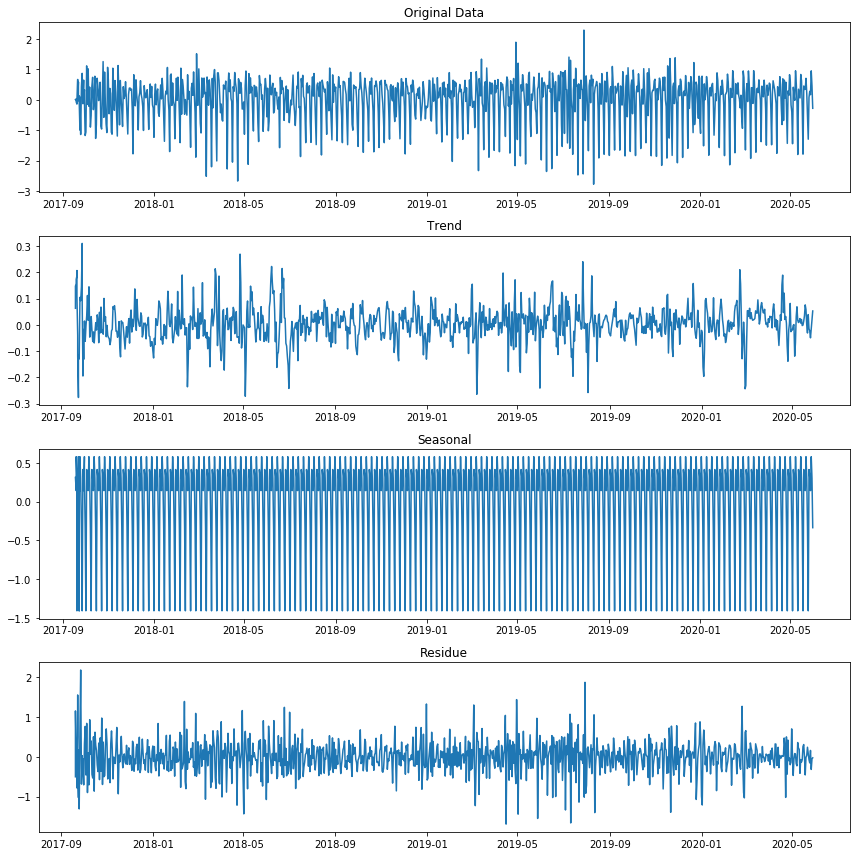

In [16]:
decomposition = seasonal_decompose(diff_log_sales, model = 'additive', period=7) 
fig, ax = plt.subplots(4,1, figsize=(12,12))
ax[0].plot(diff_log_sales)
ax[0].set_title('Original Data')
ax[1].plot(decomposition.trend)
ax[1].set_title('Trend')
ax[2].plot(decomposition.seasonal)
ax[2].set_title('Seasonal')
ax[3].plot(decomposition.resid)
ax[3].set_title('Residue')
plt.tight_layout()

print(diff_log_sales.shape)
print(decomposition.trend.shape)
print(decomposition.seasonal.shape)
print(decomposition.resid.shape)

### Plot of Residue v/s Holidays in Brazil

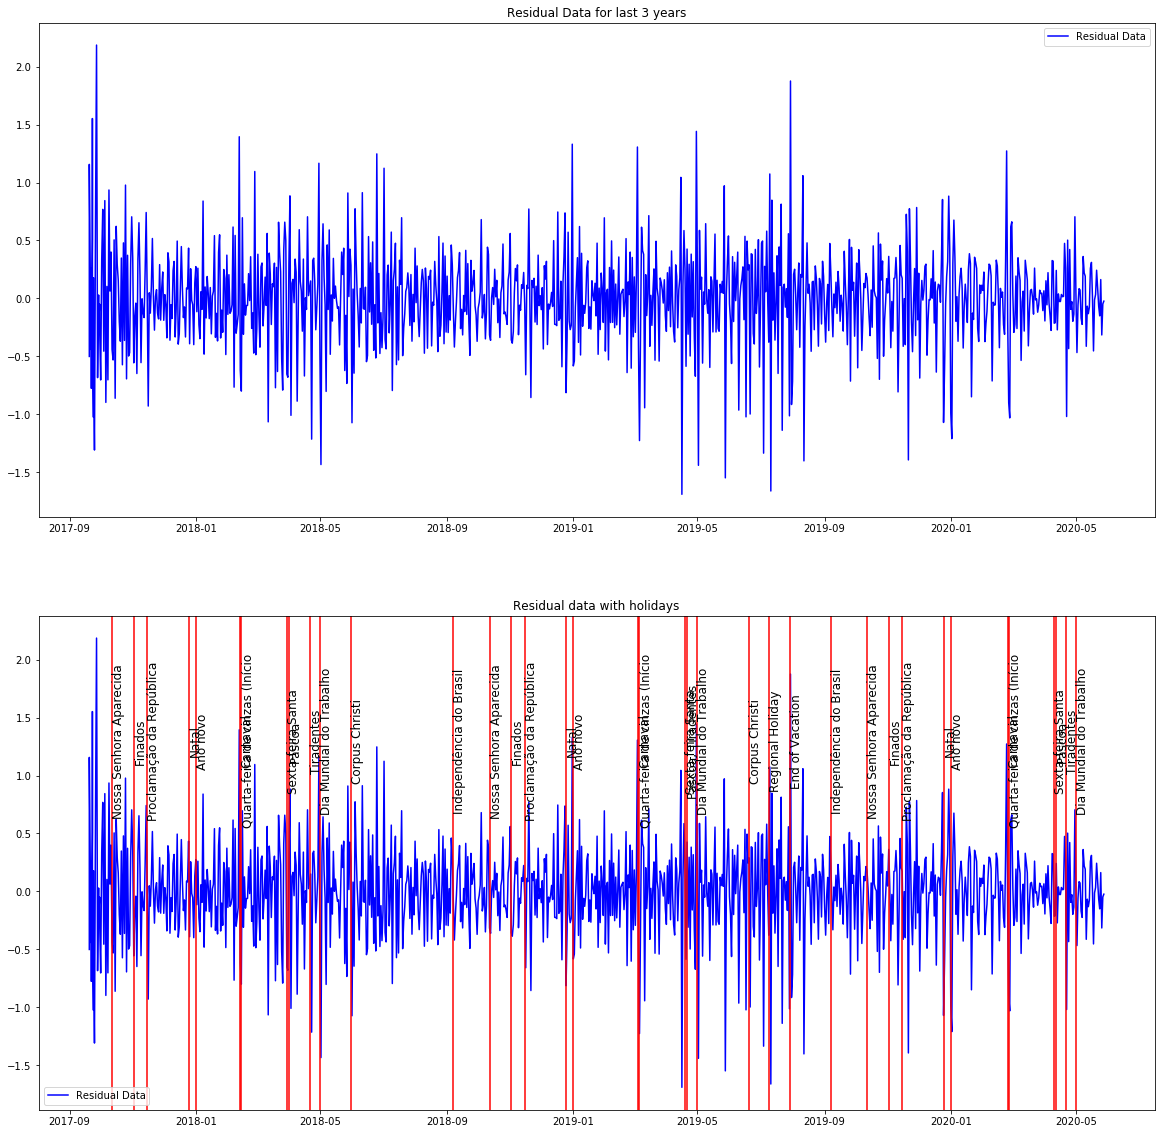

In [17]:
br_holidays = holidays.CountryHoliday('BR', years=[2017, 2018, 2019, 2020])

resid_data = decomposition.resid
ax = plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.plot(resid_data, color = 'blue', label = 'Residual Data')
plt.legend(loc = 'best')
plt.title('Residual Data for last 3 years')


plt.subplot(2,1,2)
plt.plot(resid_data, color = 'blue', label = 'Residual Data')
plt.title('Residual data with holidays')
for date, name in br_holidays.items():
    if date>decomposition.resid.index[0] and date<decomposition.resid.index[-1]:
        plt.axvline(x=date, color='red')
        text(date, 1.3, name[:30], rotation=90, verticalalignment='center', fontsize=12)
plt.axvline(x='2019-07-09', color='red')
text('2019-07-09', 1.3, 'Regional Holiday', rotation=90, verticalalignment='center', fontsize=12)
plt.axvline(x='2019-07-30', color='red')
text('2019-07-30', 1.3, 'End of Vacation', rotation=90, verticalalignment='center', fontsize=12)
plt.legend(loc='best')
plt.show()

> To get original data from diff log sales
#### np.exp(diff_log_sales.cumsum()).plot()

### Building an ARIMA model

In [19]:
diff_log_sales = diff_log_sales
train_data = diff_log_sales[:-15]
test_data = diff_log_sales[-15:]
print(train_data.shape)
print(test_data.shape)

(984,)
(15,)


### Creating exogenous variables

In [20]:
holidays_data = pd.DataFrame(columns=['day_of_week', 'is_holiday', 'is_weekend', 'is_holiday_near_weekend'], 
                             index=diff_log_sales.index)

holidays_data['day_of_week'] = holidays_data.index.map(lambda x : x.dayofweek)

mask = (holidays_data['day_of_week']==5) | (holidays_data['day_of_week']==6)
holidays_data['is_weekend'][mask] = 1
holidays_data['is_weekend'].fillna(0, inplace=True)

for date, name in br_holidays.items():
    if date > holidays_data.index[0] and date < holidays_data.index[-1]:
        mask = (holidays_data.index == pd.to_datetime(date))
        holidays_data['is_holiday'][mask] = 1
holidays_data['is_holiday'].fillna(0, inplace=True)

mask = (holidays_data['is_weekend']==1) & (holidays_data['is_holiday']==1)
holidays_data['is_holiday_near_weekend'][mask] = 1
holidays_data.fillna(0, inplace=True)

holidays_data

<ipython-input-20-2c1b847f3993>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_data['is_weekend'][mask] = 1
<ipython-input-20-2c1b847f3993>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_data['is_holiday'][mask] = 1
<ipython-input-20-2c1b847f3993>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidays_data['is_holiday_near_weekend'][mask] = 1


,day_of_week,is_holiday,is_weekend,is_holiday_near_weekend
order_date,,,,
2017-09-18,0,0,0,0
2017-09-19,1,0,0,0
2017-09-19,1,0,0,0
2017-09-20,2,0,0,0
2017-09-20,2,0,0,0
...,...,...,...,...
2020-05-27,2,0,0,0
2020-05-28,3,0,0,0
2020-05-29,4,0,0,0


In [21]:
holidays_data['is_holiday'].value_counts()

0    963
1     36
Name: is_holiday, dtype: int64

In [22]:
exog = holidays_data[['is_holiday', 'is_weekend', 'is_holiday_near_weekend']].copy()
train_exog = exog[:-15]
test_exog = exog[-15:]
print(train_exog.shape)
print(test_exog.shape)

(984, 3)
(15, 3)


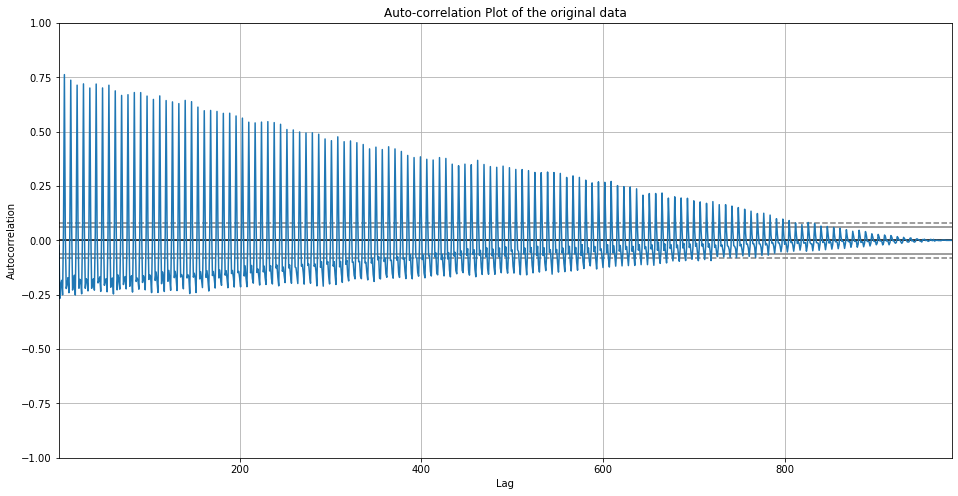

In [24]:
plt.figure(figsize=(16,8))
autocorrelation_plot(train_data)
plt.title('Auto-correlation Plot of the original data')
plt.show()

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


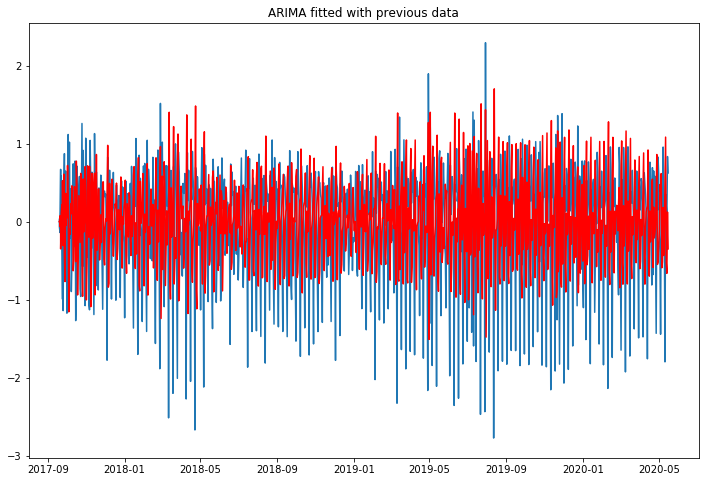

R2 Score : -0.7111372679572607


In [25]:
model1 = ARIMA(endog = train_data, order=(2,1,0))
results1 = model1.fit(disp=False)
ax = plt.figure(figsize=(12,8))
plt.plot(train_data[1:])
plt.plot(results1.fittedvalues, color='red')
plt.title('ARIMA fitted with previous data')
plt.show()

print('R2 Score :', r2_score(train_data[1:], results1.fittedvalues))

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


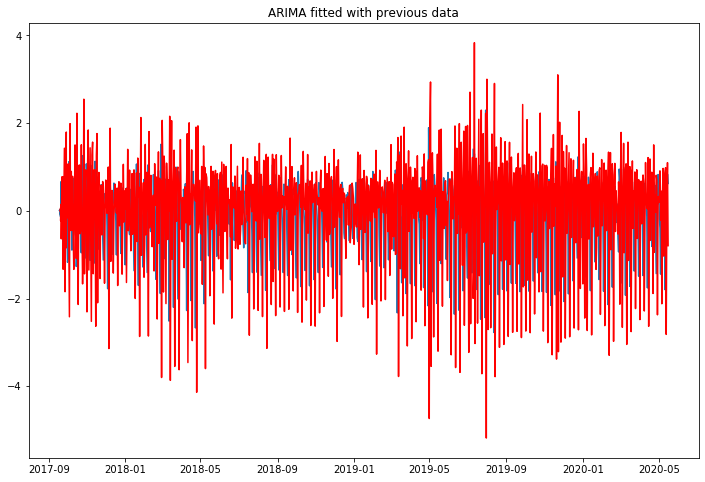

R2 Score : -3.289593774714027


In [26]:
model2 = ARIMA(endog = train_data, order=(2,2,0))
results2 = model2.fit(disp=False)
ax = plt.figure(figsize=(12,8))
plt.plot(train_data)
plt.plot(results2.fittedvalues, color='red')
plt.title('ARIMA fitted with previous data')
plt.show()

print('R2 Score :', r2_score(train_data[2:], results2.fittedvalues))

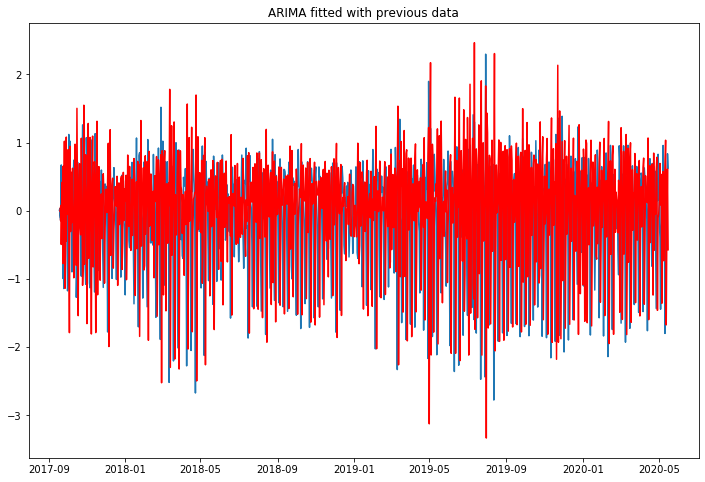

R2 Score : -1.5567183949565


In [27]:
avg_fit = (results1.fittedvalues[1:] + results2.fittedvalues)/2
avg_fit.dropna(inplace=True)
ax = plt.figure(figsize=(12,8))
plt.plot(train_data)
plt.plot(avg_fit, color='red')
plt.title('ARIMA fitted with previous data')
plt.show()

print('R2 Score :', r2_score(train_data[2:], avg_fit))

<hr />
> R2 Score is minimum with (2,1,0) <br />
> Model is not learning properly as seen from the plot below <br />
<hr />

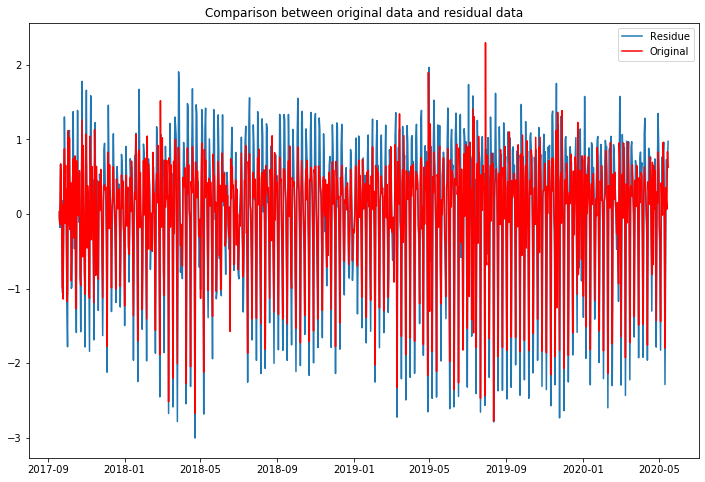

In [29]:
ax = plt.figure(figsize=(12,8))
plt.plot(train_data[1:] - results1.fittedvalues, label='Residue')
plt.plot(train_data[1:], color='red', label='Original')
plt.title('Comparison between original data and residual data')
plt.legend(loc='best')
plt.show()

# Increasing number of lags to improve model accuracy

### Taking lag of 10 days, Order = (10,0,0)

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


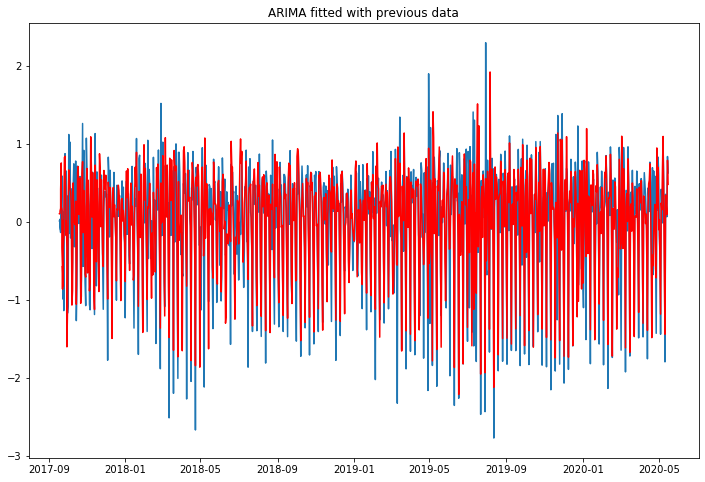

R2 Score : 0.7218277109133318


In [30]:
model = ARIMA(endog = train_data, order=(10,0,0), exog=train_exog)
results = model.fit(disp=False)
ax = plt.figure(figsize=(12,8))
plt.plot(train_data[:])
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA fitted with previous data')
plt.show()

print('R2 Score :', r2_score(train_data, results.fittedvalues))

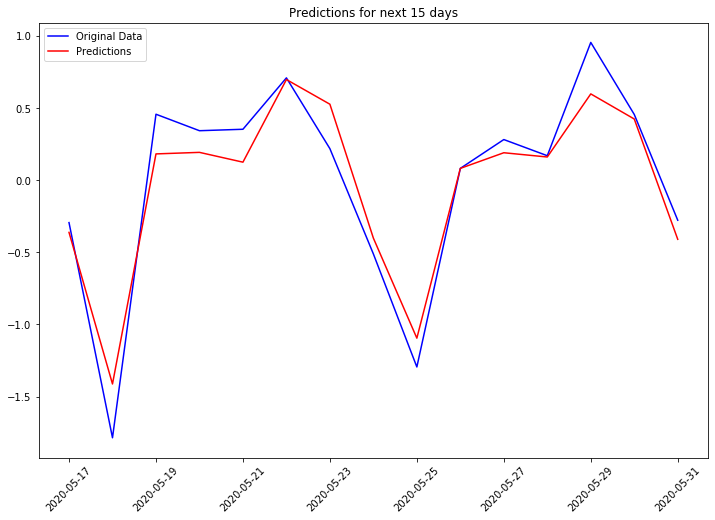

In [31]:
preds = results.forecast(15, exog=test_exog)[0]
pred_df = pd.DataFrame(columns = ['prediction'], index=test_data.index)
pred_df['prediction'] = preds
fig = plt.figure(figsize=(12,8))
plt.plot(test_data, color = 'blue', label='Original Data')
plt.plot(pred_df, color='red', label='Predictions')
plt.xticks(rotation=45)
plt.title('Predictions for next 15 days')
plt.legend(loc='best')
plt.show()

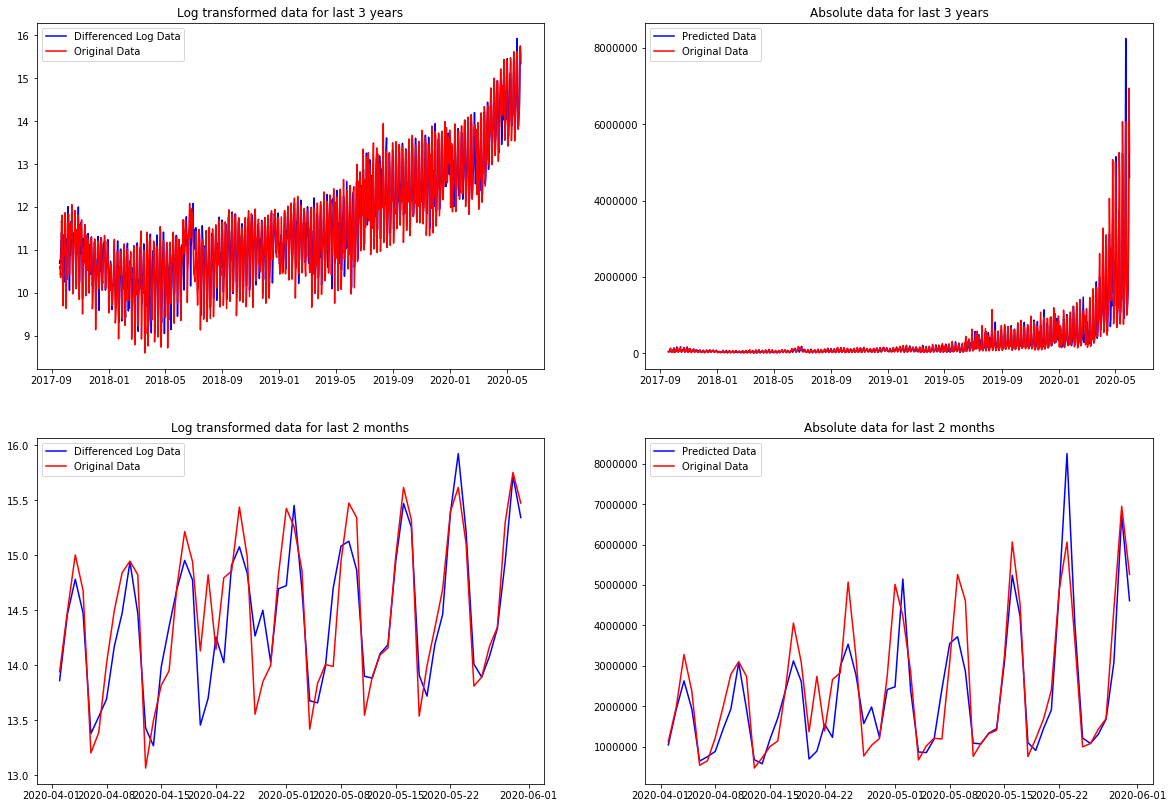

In [66]:
predicted_data = np.append(results.fittedvalues, preds)
adding_term = log_sales.shift(1).dropna()
predicted_data = predicted_data.astype(float) + adding_term
ax = plt.figure(figsize=(20,14))
plt.subplot(2,2,1)
plt.plot(predicted_data, color = 'blue', label = 'Differenced Log Data')
plt.plot(log_sales, color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Log transformed data for last 3 years')

orig_data = np.exp(predicted_data)
plt.subplot(2,2,2)
plt.plot(orig_data, color = 'blue', label = 'Predicted Data')
plt.plot(sales_data, color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Absolute data for last 3 years')

plt.subplot(2,2,3)
plt.plot(predicted_data[-60:], color = 'blue', label = 'Differenced Log Data')
plt.plot(log_sales[-60:], color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Log transformed data for last 2 months')

plt.subplot(2,2,4)
plt.plot(orig_data[-60:], color = 'blue', label = 'Predicted Data')
plt.plot(sales_data[-60:], color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Absolute data for last 2 months')

plt.show()

In [68]:
print('R2 Score for last 3 years :', r2_score(orig_data, sales_data[1:]))
print('R2 Score for last 2 months :', r2_score(orig_data[-60:], sales_data[-60:]))

R2 Score for last 3 years : 0.8990951920778472
R2 Score for last 2 months : 0.7369883250139055


### Taking lag of 10 days, Order = (10,1,0)

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


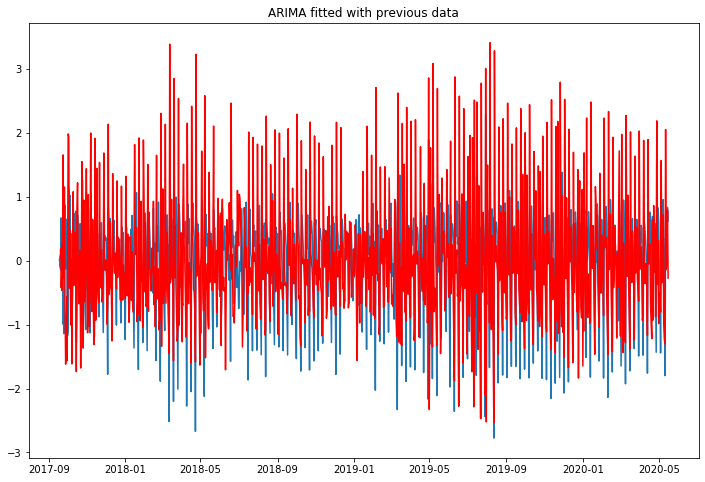

R2 Score : -0.32000758473351465


In [69]:
model = ARIMA(endog = train_data, order=(10,1,0), exog=train_exog)
results1 = model.fit(disp=False)
ax = plt.figure(figsize=(12,8))
plt.plot(train_data[:])
plt.plot(results1.fittedvalues, color='red')
plt.title('ARIMA fitted with previous data')
plt.show()

print('R2 Score :', r2_score(train_data[1:], results1.fittedvalues))

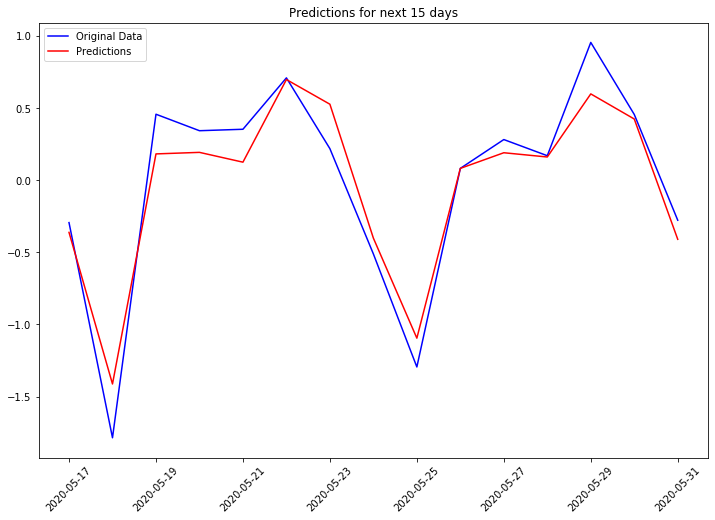

In [72]:
preds1 = results1.forecast(15, exog=test_exog)[0]
pred_df1 = pd.DataFrame(columns = ['prediction'], index=test_data.index)
pred_df1['prediction'] = preds1
fig = plt.figure(figsize=(12,8))
plt.plot(test_data, color = 'blue', label='Original Data')
plt.plot(pred_df, color='red', label='Predictions')
plt.xticks(rotation=45)
plt.title('Predictions for next 15 days')
plt.legend(loc='best')
plt.show()

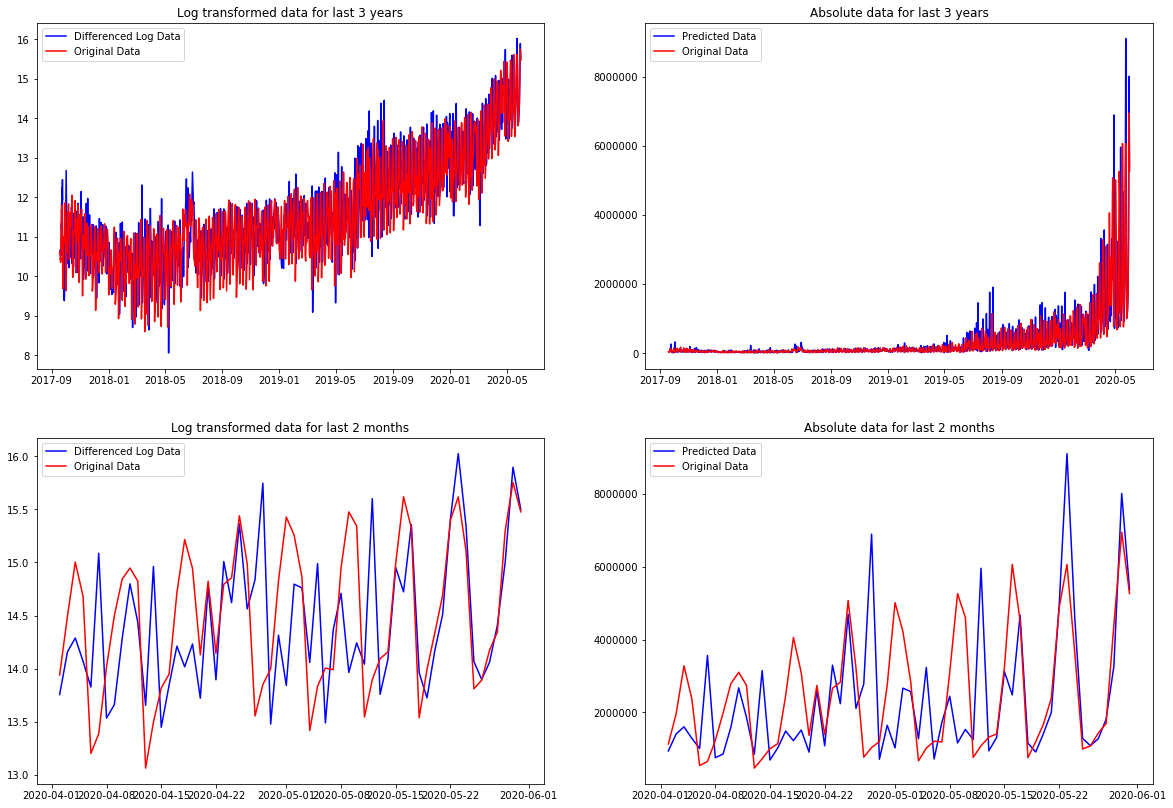

In [73]:
predicted_data1 = np.append(results1.fittedvalues, preds1)
adding_term = log_sales.shift(1).dropna()
predicted_data1 = predicted_data1.astype(float) + adding_term[1:]
ax = plt.figure(figsize=(20,14))
plt.subplot(2,2,1)
plt.plot(predicted_data1, color = 'blue', label = 'Differenced Log Data')
plt.plot(log_sales, color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Log transformed data for last 3 years')

orig_data1 = np.exp(predicted_data1)
plt.subplot(2,2,2)
plt.plot(orig_data1, color = 'blue', label = 'Predicted Data')
plt.plot(sales_data, color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Absolute data for last 3 years')

plt.subplot(2,2,3)
plt.plot(predicted_data1[-60:], color = 'blue', label = 'Differenced Log Data')
plt.plot(log_sales[-60:], color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Log transformed data for last 2 months')

plt.subplot(2,2,4)
plt.plot(orig_data1[-60:], color = 'blue', label = 'Predicted Data')
plt.plot(sales_data[-60:], color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Absolute data for last 2 months')

plt.show()

In [75]:
print('R2 Score for last 3 years :', r2_score(orig_data1, sales_data[2:]))
print('R2 Score for last 2 months :', r2_score(orig_data1[-60:], sales_data[-60:]))

R2 Score for last 3 years : 0.541918629695619
R2 Score for last 2 months : 0.10151991977623132


### Taking lag of 14 days, Order = (14,0,0)

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


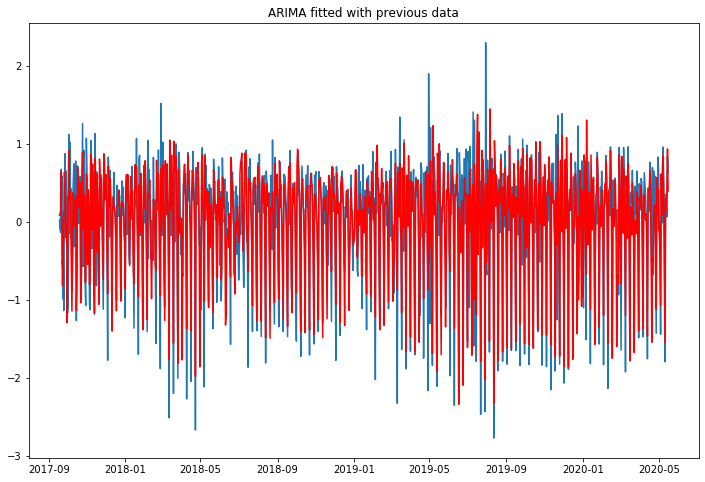

R2 Score : 0.7607701930426569


In [76]:
model = ARIMA(endog = train_data, order=(14,0,0), exog=train_exog)
results2 = model.fit(disp=False)
ax = plt.figure(figsize=(12,8))
plt.plot(train_data[:])
plt.plot(results2.fittedvalues, color='red')
plt.title('ARIMA fitted with previous data')
plt.show()

print('R2 Score :', r2_score(train_data, results2.fittedvalues))

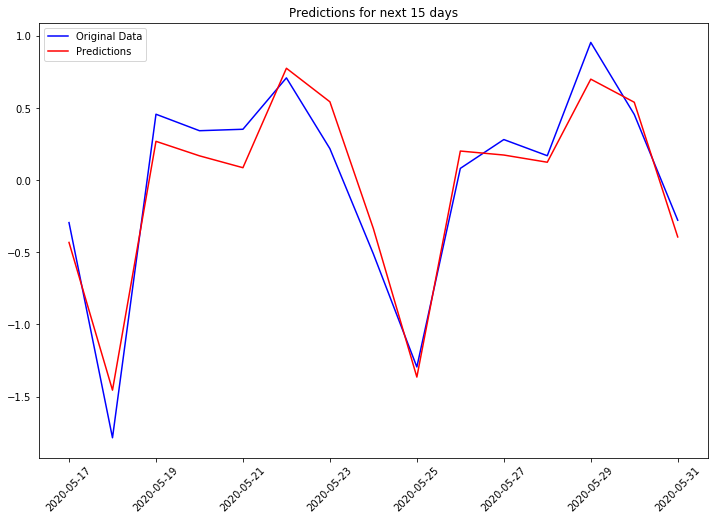

In [77]:
preds2 = results2.forecast(15, exog=test_exog)[0]
pred_df2 = pd.DataFrame(columns = ['prediction'], index=test_data.index)
pred_df2['prediction'] = preds2
fig = plt.figure(figsize=(12,8))
plt.plot(test_data, color = 'blue', label='Original Data')
plt.plot(pred_df2, color='red', label='Predictions')
plt.xticks(rotation=45)
plt.title('Predictions for next 15 days')
plt.legend(loc='best')
plt.show()

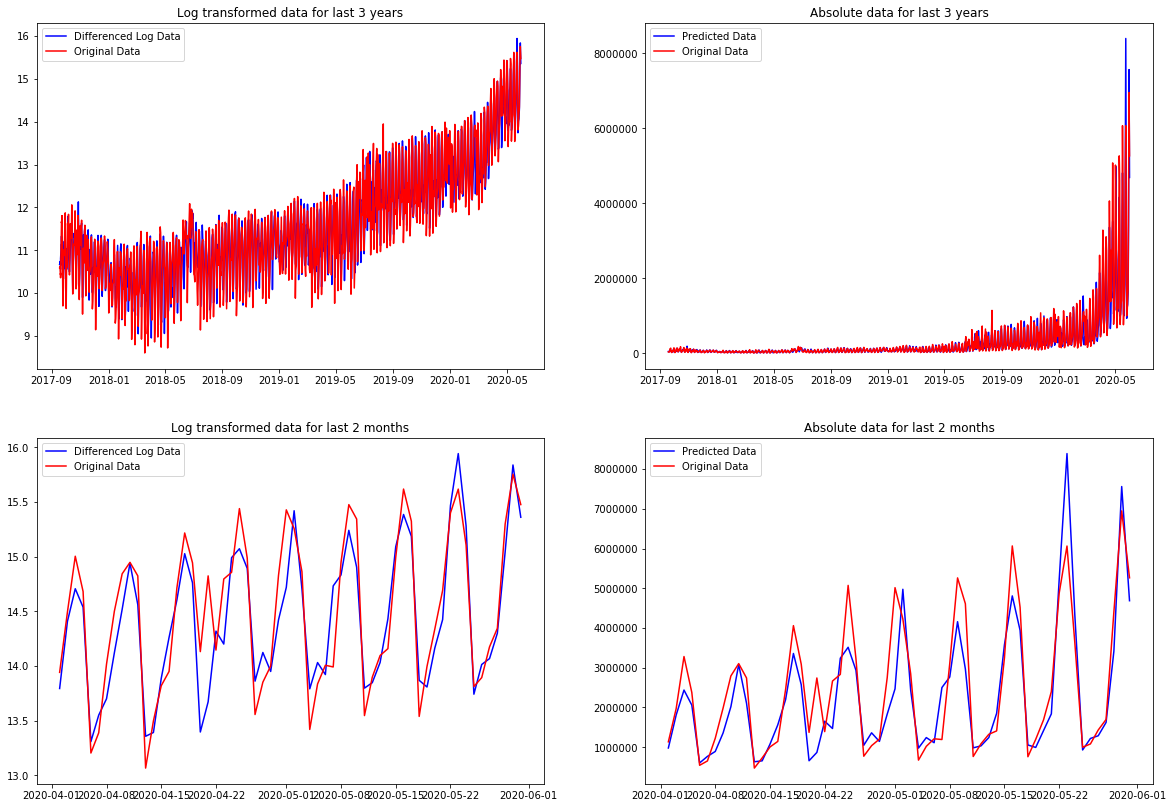

In [79]:
predicted_data2 = np.append(results2.fittedvalues, preds2)
adding_term = log_sales.shift(1).dropna()
predicted_data2 = predicted_data2.astype(float) + adding_term
ax = plt.figure(figsize=(20,14))
plt.subplot(2,2,1)
plt.plot(predicted_data2, color = 'blue', label = 'Differenced Log Data')
plt.plot(log_sales, color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Log transformed data for last 3 years')

orig_data2 = np.exp(predicted_data2)
plt.subplot(2,2,2)
plt.plot(orig_data2, color = 'blue', label = 'Predicted Data')
plt.plot(sales_data, color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Absolute data for last 3 years')

plt.subplot(2,2,3)
plt.plot(predicted_data2[-60:], color = 'blue', label = 'Differenced Log Data')
plt.plot(log_sales[-60:], color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Log transformed data for last 2 months')

plt.subplot(2,2,4)
plt.plot(orig_data2[-60:], color = 'blue', label = 'Predicted Data')
plt.plot(sales_data[-60:], color = 'red', label = 'Original Data')
plt.legend(loc = 'best')
plt.title('Absolute data for last 2 months')

plt.show()

In [80]:
print('R2 Score for last 3 years :', r2_score(orig_data2, sales_data[1:]))
print('R2 Score for last 2 months :', r2_score(orig_data2[-60:], sales_data[-60:]))

R2 Score for last 3 years : 0.9070466739793444
R2 Score for last 2 months : 0.7676633374570392
